In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definiere die Spaltennamen (Feature-Namen)
# Einheit, Zeit-Zyklus, drei Einstell-Parameter, 21 Sensoren
columns = ['UnitNumber', 'TimeInCycles', 
           'Setting1', 'Setting2', 'Setting3'] + \
          [f'Sensor{i}' for i in range(1, 22)]

# Datenpfad anpassen, falls du nicht FD001 nutzt
data_path = 'data/train_FD001.txt' 

# Lade die Trainingsdaten
# Der Datensatz hat keine Header, deshalb 'header=None' und der Separator ist ein Leerzeichen
df = pd.read_csv(data_path, sep='\s+', header=None, names=columns)

# Zeige die ersten 5 Zeilen
print("Datenstruktur:")
print(df.head())
print("\nStatistische Übersicht:")
print(df.describe().transpose())

Datenstruktur:
   UnitNumber  TimeInCycles  Setting1  Setting2  Setting3  Sensor1  Sensor2  \
0           1             1   -0.0007   -0.0004     100.0   518.67   641.82   
1           1             2    0.0019   -0.0003     100.0   518.67   642.15   
2           1             3   -0.0043    0.0003     100.0   518.67   642.35   
3           1             4    0.0007    0.0000     100.0   518.67   642.35   
4           1             5   -0.0019   -0.0002     100.0   518.67   642.37   

   Sensor3  Sensor4  Sensor5  ...  Sensor12  Sensor13  Sensor14  Sensor15  \
0  1589.70  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195   
1  1591.82  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318   
2  1587.99  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178   
3  1582.79  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682   
4  1582.85  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294   

   Sensor16  Sensor17  Sensor18  Sensor19  Sens


Daten mit RUL-Spalte:
       UnitNumber  TimeInCycles  Setting1  Setting2  Setting3  Sensor1  \
20626         100           196   -0.0004   -0.0003     100.0   518.67   
20627         100           197   -0.0016   -0.0005     100.0   518.67   
20628         100           198    0.0004    0.0000     100.0   518.67   
20629         100           199   -0.0011    0.0003     100.0   518.67   
20630         100           200   -0.0032   -0.0005     100.0   518.67   

       Sensor2  Sensor3  Sensor4  Sensor5  ...  Sensor14  Sensor15  Sensor16  \
20626   643.49  1597.98  1428.63    14.62  ...   8137.60    8.4956      0.03   
20627   643.54  1604.50  1433.58    14.62  ...   8136.50    8.5139      0.03   
20628   643.42  1602.46  1428.18    14.62  ...   8141.05    8.5646      0.03   
20629   643.23  1605.26  1426.53    14.62  ...   8139.29    8.5389      0.03   
20630   643.85  1600.38  1432.14    14.62  ...   8137.33    8.5036      0.03   

       Sensor17  Sensor18  Sensor19  Sensor20  Sens

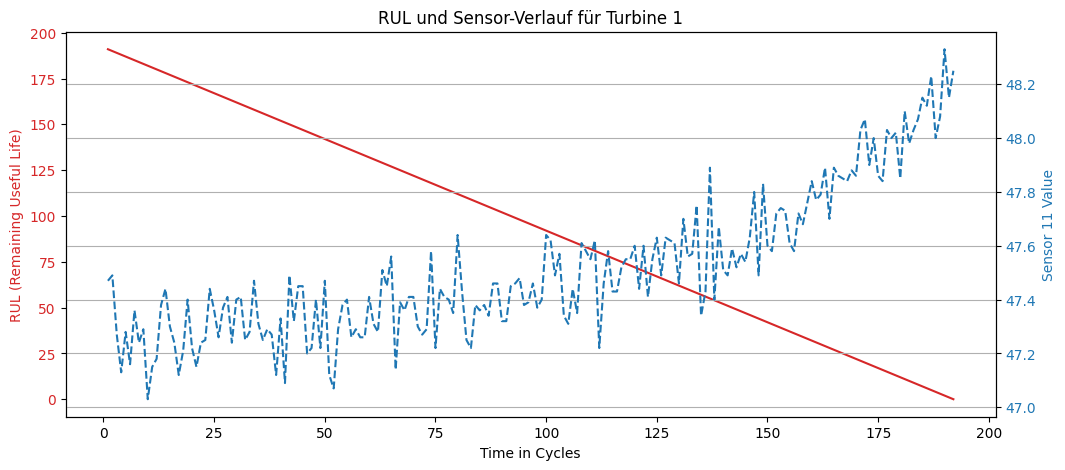

In [5]:
# Berechne den maximalen Zyklus für jede Unit
max_cycles = df.groupby('UnitNumber')['TimeInCycles'].max().reset_index()
max_cycles.columns = ['UnitNumber', 'MaxTime']

# Füge die maximale Zeit zurück in den Haupt-DataFrame
df = df.merge(max_cycles, on='UnitNumber', how='left')

# Berechne RUL (Remaining Useful Life): MaxTime - TimeInCycles
df['RUL'] = df['MaxTime'] - df['TimeInCycles']

print("\nDaten mit RUL-Spalte:")
print(df.tail())

# Jetzt plotten wir den RUL und einen interessanten Sensor für EINE Turbine (z.B. Turbine 1)
unit_id = 1
df_unit = df[df['UnitNumber'] == unit_id]

# Plot: RUL vs. Zeit
fig, ax1 = plt.subplots(figsize=(12, 5))

# Achse 1: RUL (Zielvariable)
color = 'tab:red'
ax1.set_xlabel('Time in Cycles')
ax1.set_ylabel('RUL (Remaining Useful Life)', color=color)
ax1.plot(df_unit['TimeInCycles'], df_unit['RUL'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Achse 2: Ein aussagekräftiger Sensor (z.B. Sensor 11: Fan pressure ratio)
ax2 = ax1.twinx() # Achsen teilen sich die X-Achse
color = 'tab:blue'
ax2.set_ylabel('Sensor 11 Value', color=color) 
ax2.plot(df_unit['TimeInCycles'], df_unit['Sensor11'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'RUL und Sensor-Verlauf für Turbine {unit_id}')
plt.grid(True)
plt.show()

In [6]:
# Liste der Spalten, die konstant (oder quasi-konstant) sind und entfernt werden
cols_to_drop = ['Setting3', 'Sensor1', 'Sensor5', 'Sensor6', 
                'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19'] 

# Wir entfernen auch die Hilfsspalten 'MaxTime' und 'TimeInCycles' für das Training,
# da RUL direkt aus diesen berechnet wurde (und RUL unser y ist).
df_processed = df.drop(columns=['MaxTime', 'TimeInCycles'] + cols_to_drop)
print(f"Daten-Shape nach Feature Selection: {df_processed.shape}")

Daten-Shape nach Feature Selection: (20631, 18)


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Wir normalisieren ALLE Spalten, außer UnitNumber und RUL (unser y).
# Wir speichern den MinMaxScaler, da wir ihn später für neue Testdaten brauchen.
scaler = MinMaxScaler()

# Die Spalten, die normalisiert werden sollen (alles außer UnitNumber und RUL)
cols_to_scale = df_processed.columns.drop(['UnitNumber', 'RUL'])

# Normalisiere die Daten und ersetze die Spalten im DataFrame
df_processed[cols_to_scale] = scaler.fit_transform(df_processed[cols_to_scale])

print("\nDatenstruktur nach Normalisierung (Werte 0 bis 1):")
print(df_processed.head())


Datenstruktur nach Normalisierung (Werte 0 bis 1):
   UnitNumber  Setting1  Setting2   Sensor2   Sensor3   Sensor4   Sensor7  \
0           1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1           1  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2           1  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3           1  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4           1  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

    Sensor8   Sensor9  Sensor11  Sensor12  Sensor13  Sensor14  Sensor15  \
0  0.242424  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986   
1  0.212121  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312   
2  0.272727  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445   
3  0.318182  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603   
4  0.242424  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078   

   Sensor17  Sensor20  Sensor21  R

In [13]:
def create_sequences(df_unit, sequence_length):
    """
    Wandelt die Zeitreihendaten einer einzelnen Turbine in Sequenzen um.
    """
    X, y = [], []
    features = df_unit.drop(columns=['UnitNumber', 'RUL']).values # Nur die normalisierten Sensoren
    # WICHTIG: Definiere den Clamping-Wert (Hyperparameter)
    rul = df_unit['RUL'].values
    MAX_RUL = 125 

    # Führe das Clamping durch: RUL ist maximal MAX_RUL
    df['RUL'] = df['RUL'].clip(upper=MAX_RUL)

    print(f"\nMaximaler RUL-Wert nach Clamping: {df['RUL'].max()}")

    for i in range(len(features) - sequence_length + 1):
        # X: Die Sensordaten der letzten 'sequence_length' Zyklen
        X.append(features[i:i + sequence_length])
        
        # y: Der RUL-Wert des LETZTEN Zyklus in dieser Sequenz
        y.append(rul[i + sequence_length - 1])
        
    return np.array(X), np.array(y)

# Definiere die Sequenzlänge (Sliding Window). 
# Wir nehmen z.B. 30 Zyklen Historie, um RUL vorherzusagen.
SEQUENCE_LENGTH = 30 

# Führe die Sequenz-Erstellung für ALLE Units aus
X_data, y_data = [], []

for unit_id in df_processed['UnitNumber'].unique():
    df_unit = df_processed[df_processed['UnitNumber'] == unit_id]
    
    # Ignoriere Units, die kürzer sind als die Sequenzlänge
    if len(df_unit) >= SEQUENCE_LENGTH:
        X_unit, y_unit = create_sequences(df_unit, SEQUENCE_LENGTH)
        X_data.append(X_unit)
        y_data.append(y_unit)

# Konkateniere die Daten aller Units
X_final = np.concatenate(X_data, axis=0)
y_final = np.concatenate(y_data, axis=0)

print(f"\nFinales Daten-Shape für PyTorch-Input:")
print(f"X (Input Sequenzen): {X_final.shape}")
print(f"y (Output RUL Werte): {y_final.shape}")


Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach Clamping: 125

Maximaler RUL-Wert nach 

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 1. NumPy Arrays in PyTorch Tensoren umwandeln
# Wir benötigen Float32 für das Training
X_tensor = torch.tensor(X_final, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.float32).unsqueeze(1) # Unsqueeze(1) fügt eine Dimension hinzu (wichtig für Regression)

# 2. Daten aufteilen in Training und Validierung (z.B. 80/20 Split)
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 3. DataLoaders erstellen
# Diese helfen, die Daten effizient und in kleinen "Batches" (Stapel) an das Modell zu übergeben.
BATCH_SIZE = 64 # Eine typische Batch-Größe

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Anzahl Trainings-Batches: {len(train_loader)}")
print(f"Anzahl Validierungs-Datenpunkte: {len(y_val)}")

Anzahl Trainings-Batches: 222
Anzahl Validierungs-Datenpunkte: 3547


In [16]:
import torch.nn as nn

# Wir bestimmen die Eingangs- und Ausgangsgrößen
# X_final.shape war (N, SEQUENCE_LENGTH, ANZAHL_FEATURES)
INPUT_SIZE = X_final.shape[2] # Anzahl der Sensoren (Features)
HIDDEN_SIZE = 50              # Anzahl der Neuronen in der LSTM-Schicht (Hyperparameter)
NUM_LAYERS = 2                # Anzahl der LSTM-Schichten, die übereinander gestapelt sind (Deep Learning!)
OUTPUT_SIZE = 1               # Wir sagen nur eine Zahl voraus: RUL

class LSTMRULPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRULPredictor, self).__init__()
        
        # 1. Die LSTM-Schicht: Verarbeitet die Sequenz
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True # Wichtig: Batch-Dimension ist zuerst (Batch, Sequence, Features)
        )
        
        # 2. Die finale Schicht (Fully Connected): 
        # Reduziert den LSTM-Output auf unseren gewünschten RUL-Wert (Output_Size=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 'h_n' und 'c_n' sind die Hidden- und Cell-States (werden hier nicht direkt benötigt)
        # 'output' ist der Output der LSTM-Schicht für JEDEN Zeitschritt
        output, (h_n, c_n) = self.lstm(x)
        
        # Wir interessieren uns nur für den Output des LETZTEN Zeitschritts der Sequenz
        # da dieser den kumulierten Zustand der gesamten Historie repräsentiert.
        last_output = output[:, -1, :] 
        
        # Leite den letzten Output durch die Fully Connected Layer, um den RUL zu erhalten
        prediction = self.fc(last_output)
        return prediction

# Modell instanziieren
model = LSTMRULPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
print("\nModell-Architektur:")
print(model)


Modell-Architektur:
LSTMRULPredictor(
  (lstm): LSTM(16, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [17]:
# Definition der Hyperparameter
NUM_EPOCHS = 25
LEARNING_RATE = 0.001 

# Setup
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nStarte Training für {NUM_EPOCHS} Epochen...")

# ****************** Der Training Loop ******************
for epoch in range(NUM_EPOCHS):
    model.train() # Setze das Modell in den Trainingsmodus
    train_loss = 0.0
    
    # Training über alle Batches
    for inputs, targets in train_loader:
        # 1. Gradienten zurücksetzen
        optimizer.zero_grad()
        
        # 2. Forward Pass: Vorhersage machen
        outputs = model(inputs)
        
        # 3. Loss berechnen
        loss = criterion(outputs, targets)
        
        # 4. Backward Pass: Gradienten berechnen
        loss.backward()
        
        # 5. Gewichte anpassen
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

    # Durchschnittlichen Trainings-Loss berechnen
    epoch_train_loss = train_loss / len(train_dataset)
    
    # ****************** Der Validierungs Loop ******************
    model.eval() # Setze das Modell in den Validierungsmodus (keine Gradienten)
    val_loss = 0.0
    
    with torch.no_grad(): # Deaktiviert die Berechnung von Gradienten
        for inputs_val, targets_val in val_loader:
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)
            val_loss += loss_val.item() * inputs_val.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

print("Training abgeschlossen!")


Starte Training für 25 Epochen...
Epoch [1/25], Train Loss: 11127.4670, Val Loss: 9896.4813
Epoch [2/25], Train Loss: 9213.2999, Val Loss: 8340.0700
Epoch [3/25], Train Loss: 7819.2264, Val Loss: 7126.1793
Epoch [4/25], Train Loss: 6727.0128, Val Loss: 6178.4749
Epoch [5/25], Train Loss: 5881.5806, Val Loss: 5456.1113
Epoch [6/25], Train Loss: 5240.7013, Val Loss: 4916.2310
Epoch [7/25], Train Loss: 4767.5565, Val Loss: 4525.3831
Epoch [8/25], Train Loss: 4428.8674, Val Loss: 4253.8989
Epoch [9/25], Train Loss: 4195.8604, Val Loss: 4072.9101
Epoch [10/25], Train Loss: 4042.8052, Val Loss: 3958.0226
Epoch [11/25], Train Loss: 3947.9325, Val Loss: 3891.2654
Epoch [12/25], Train Loss: 3892.8566, Val Loss: 3855.1402
Epoch [13/25], Train Loss: 3862.6433, Val Loss: 3836.4606
Epoch [14/25], Train Loss: 3847.5365, Val Loss: 3828.9500
Epoch [15/25], Train Loss: 3840.6079, Val Loss: 3826.2237
Epoch [16/25], Train Loss: 3837.6823, Val Loss: 3825.6103
Epoch [17/25], Train Loss: 3836.6435, Val Los

In [19]:
# Lade die Testdaten (ersetze den Pfad falls nötig)
test_data_path = 'data/test_FD001.txt' 
df_test = pd.read_csv(test_data_path, sep='\s+', header=None, names=columns)

# **WICHTIG:** Hier definieren wir noch einmal ALLE Spalten, die wir aus dem TRAINING 
# herausgenommen haben (Setting3, TimeInCycles, MaxTime etc.)
# Wir verwenden die gleichen Variablen wie in Code-Block 3
full_cols_to_drop = ['MaxTime', 'TimeInCycles'] + cols_to_drop 

# 1. Feature Selection (Die gleichen Spalten entfernen wie beim Training)
# Jetzt entfernen wir ALLE nicht benötigten Spalten explizit
df_test_processed = df_test.drop(columns=full_cols_to_drop, errors='ignore') # 'errors='ignore' verhindert Fehler, falls eine Spalte doch fehlt

# 2. RUL-Spalte hinzufügen (Platzhalter für die Sequenz-Erstellung)
df_test_processed['RUL'] = 0 # Dummy-Wert
df_test_processed['UnitNumber'] = df_test_processed['UnitNumber'] 

# 3. Normalisierung (NUR transform!)
# Die Spalten für das Skalieren sind nun alle Features außer UnitNumber und RUL
test_cols_to_scale = df_test_processed.columns.drop(['UnitNumber', 'RUL'])

# WICHTIG: Verwende den 'scaler', den du beim Training erstellt hast!
df_test_processed[test_cols_to_scale] = scaler.transform(df_test_processed[test_cols_to_scale]) 

# 4. Sequenz-Erstellung (NUR die letzte Sequenz jeder Unit ist relevant für die RUL-Vorhersage)
X_test_list = []
y_test_list = [] # Hier kommen die wahren RUL-Werte hin (werden später geladen)

for unit_id in df_test_processed['UnitNumber'].unique():
    df_unit = df_test_processed[df_test_processed['UnitNumber'] == unit_id]
    
    # Wir nehmen nur die letzte Sequenz der Beobachtungen (die neuesten 30 Zyklen)
    if len(df_unit) >= SEQUENCE_LENGTH:
        X_test_list.append(df_unit.drop(columns=['UnitNumber', 'RUL']).values[-SEQUENCE_LENGTH:])
    # Bei Units, die kürzer als 30 Zyklen sind, müssen wir auffüllen (Padding), das überspringen wir hier.

X_test_final = np.array(X_test_list)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)

print(f"Finales Test-Shape für PyTorch-Input: {X_test_tensor.shape}")

Finales Test-Shape für PyTorch-Input: torch.Size([100, 30, 16])


In [23]:
# Lade die wahren RUL-Werte für die Test-Units
true_rul = pd.read_csv('data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
true_rul_values = true_rul['RUL'].values
# HINWEIS: Hier die MAX_RUL Definition einfügen, falls die Zelle 9 nicht lief
MAX_RUL = 125
# Wir müssen hier die Clamping-Logik anwenden, um einen fairen Vergleich zu haben!
# Wir clamen die wahren RUL-Werte auf 125 Zyklen
y_true_clamped = np.clip(true_rul_values[:len(X_test_tensor)], a_min=None, a_max=MAX_RUL)
y_true_tensor = torch.tensor(y_true_clamped, dtype=torch.float32).unsqueeze(1)

# Setze das Modell in den Evaluationsmodus
model.eval() 

with torch.no_grad():
    # Mache die Vorhersagen
    y_pred_tensor = model(X_test_tensor)

# Konvertiere zurück zu NumPy für die Metrik-Berechnung
y_pred = y_pred_tensor.squeeze().numpy()
y_true = y_true_tensor.squeeze().numpy()

# Berechne den finalen Mean Squared Error (MSE) auf den Testdaten
test_mse = np.mean((y_pred - y_true)**2)
test_rmse = np.sqrt(test_mse)

print(f"\n--- Finale Test-Performance (nach RUL Clamping) ---")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE (in Zyklen): {test_rmse:.4f}")
print(f"Vorhergesagter RUL für die ersten 5 Turbinen: {y_pred[:5].round(1)}")
print(f"Wahrer RUL für die ersten 5 Turbinen:        {y_true[:5].round(1)}")


--- Finale Test-Performance (nach RUL Clamping) ---
Test MSE: 1993.8644
Test RMSE (in Zyklen): 44.6527
Vorhergesagter RUL für die ersten 5 Turbinen: [94.1 94.1 94.1 94.1 94.1]
Wahrer RUL für die ersten 5 Turbinen:        [112.  98.  69.  82.  91.]
